# TIME SERIES DECODER ONLY TRANSFORMER



In [50]:
# IMPORTS:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
from transformer_components import *
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# References: 
# https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch

## Define transformer 

In [51]:
class Decoder_Transformer(nn.Module):
    def __init__(self,pred_length, setups, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Decoder_Transformer, self).__init__()
        #self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model) #REMOVE EMBEDDING LAYER
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length,setups)
        self.decoder_layers = nn.ModuleList([OnlyDecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, 2)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, tgt):
        tgt_mask = (tgt != 0).unsqueeze(3)
        #print('target mask',tgt_mask.shape,tgt_mask)
        
        seq_length = tgt.size(2)
        nopeak_mask = (1 - torch.triu(torch.ones(1,2, seq_length, seq_length), diagonal=1)).bool()
        #print(nopeak_mask)
        #print('no peak mask',nopeak_mask.shape)
        
        tgt_mask = tgt_mask & nopeak_mask
        #print('mask',tgt_mask)
        return tgt_mask

    def forward(self, tgt):
        tgt_mask = self.generate_mask(tgt)
        #print("tgt",type(tgt),tgt)
        #print('pos enc', type(self.positional_encoding(tgt)), self.positional_encoding(tgt))
        tgt_embedded = self.dropout(self.positional_encoding(tgt))
        

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, tgt_mask)

        #print(dec_output.shape)
        output = self.fc(dec_output)
        return output

## Prepare Data

Data is generated from an optimal control problem with input var x and control var u subject to

    dx/dt = 1 + u(t)**2
    x(0) = 1

Data is generated using the follwoing functions: 

Function 1 (optimal): 
    u = 1/(2*(2-t)), 
    x = t + 1/(8-(4*t))

Function 2:
    u = 1/t, 
    x = t - (1/t)
   
Function 3:
    u = 2*t, 
    x = t + (4*(t**3))/3

<img src="images\toy_pos_control_all_funcs.jpg" alt="drawing" width="500"/> 
<img src="images\toy_pos_control_func_13.jpg" alt="drawing" width="500"/> 

<img src="images\toy_dxdt_all_funcs.jpg" alt="drawing" width="500"/> 
<img src="images\toy_dxdt_funcs_13.jpg" alt="drawing" width="500"/> 

In [52]:
# Define data processing parameters
num_setups = 3      # number of different u functions used to generate data
split_time = 0.5   # time to split data from a scale of 0 to 1

In [53]:
# Read data file
df = pd.read_csv("data.csv",sep=',', header=0,index_col=False)

# Replace inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)  

# Forward fill NaNs (fill with last valid value)
df.fillna(method='ffill', inplace=True)  

# Split timeseries data into training and test data
train_data = df[df['time'] < split_time]  
test_data = df[df['time'] >= split_time]  

# Print
print('df: \n',df.head())
print('train shape: ', train_data.shape)
print('test shape:  ', test_data.shape)

df: 
        time         u         x
0  0.000000  0.000000  1.000000
1  0.010101  0.251269  0.135736
2  0.020202  0.252551  0.146478
3  0.030303  0.253846  0.157226
4  0.040404  0.255155  0.167981
train shape:  (150, 3)
test shape:   (150, 3)


train shape:  (3, 50, 2)
test shape:   (3, 50, 2)


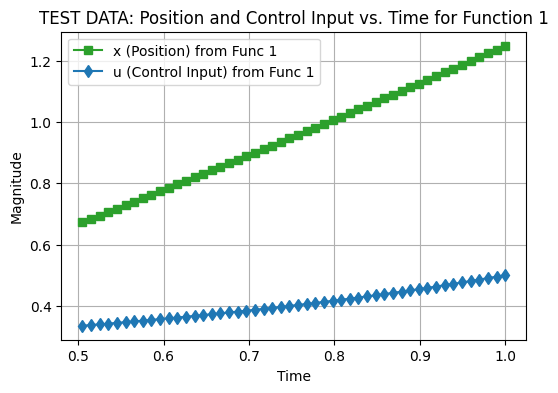

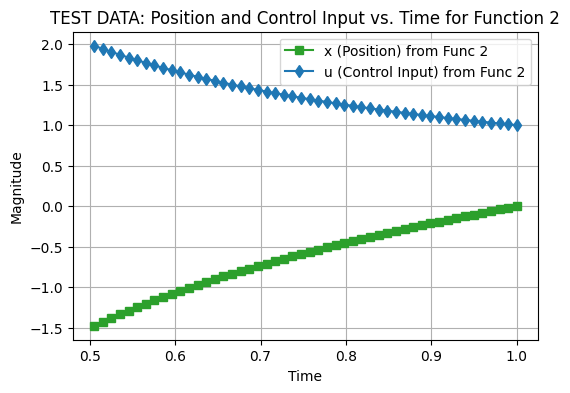

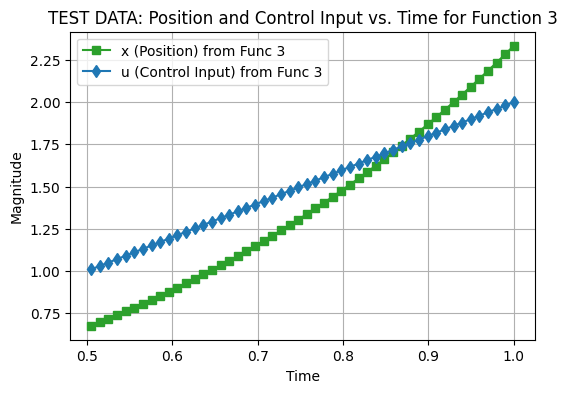

In [54]:
# Select position and control columns
train_array = train_data[['x', 'u']]
test_array = test_data[['x', 'u']]
train_time = train_data[['time']]
test_time = test_data[['time']]
#print(test_array)

# Reshape test and train arrays
train_array = train_array.to_numpy().reshape(num_setups, train_array.shape[0]//num_setups,2)
test_array = test_array.to_numpy().reshape(num_setups, test_array.shape[0]//num_setups,2)
train_time = train_time.to_numpy().reshape(num_setups,  test_time.shape[0]//num_setups)
test_time = test_time.to_numpy().reshape(num_setups,  test_time.shape[0]//num_setups)
#print('time',test_time)

# Print results
print('train shape: ', train_array.shape)
print('test shape:  ', test_array.shape)

#print('train data: ',train_array)


for i in range(train_array.shape[0]):
    plt.figure(i,figsize=(6, 4))
    plt.plot(test_time[0], test_array[i,:, 0], 's-',color='C2', label=f'x (Position) from Func {i+1}')
    plt.plot(test_time[0], test_array[i,:, 1], 'd-',color='C0', label=f'u (Control Input) from Func {i+1}')
    
    plt.title(f'TEST DATA: Position and Control Input vs. Time for Function {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)
    plt.show()


In [55]:
def create_sequences(data, sequence_length, pred_length):
    inputs = []
    targets =[]
    
    for setup in data:
        # print('setup',setup)
        # print('input', setup[:,:sequence_length-pred_length])
        # print('target', setup[:,pred_length:sequence_length:])
        inputs.append(setup[:sequence_length-pred_length,:])
        targets.append(setup[pred_length:sequence_length:,:]) # predict only u values

    return np.array(inputs), np.array(targets)

# Create sequences 
pred_length = 30   # e.g. pred_length=2 --> data: [1,2,3,4,5], x = [1,2,], y = [3,4,5]
# with train shpae 50 and pred_length 30 --> x_train: 0:20 and y_train: 30:50 (no overlap)
### ADD VISUALISATION OF DATA SEQUENCES

x_train, y_train = create_sequences(train_array,train_array.shape[1], pred_length)
x_test, y_test = create_sequences(test_array, test_array.shape[1], pred_length)

# Print results
print('x train shape: ', x_train.shape)
print('y train shape: ', y_train.shape)
print('x test shape: ', x_test.shape)
print('y test shape: ', y_test.shape)
#print('x_train: ', x_train)

x train shape:  (3, 20, 2)
y train shape:  (3, 20, 2)
x test shape:  (3, 20, 2)
y test shape:  (3, 20, 2)


In [56]:
# Convert test and train data to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).transpose(1,2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).transpose(1,2)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).transpose(1,2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).transpose(1,2)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#Print
print('x train shape: ', x_train_tensor.shape) #shape: num setups, num inputs, length sequence
print('y train shape: ', y_train_tensor.shape)
print('x test shape: ', x_test_tensor.shape)
print('y test shape: ', y_test_tensor.shape)

x train shape:  torch.Size([3, 2, 20])
y train shape:  torch.Size([3, 2, 20])
x test shape:  torch.Size([3, 2, 20])
y test shape:  torch.Size([3, 2, 20])


## Set Transformer Parameters

In [57]:

# define transformer size
d_model = 2                             # dimension of data 2 --> x,u
num_heads = 2                           # number of attention heads for multihead attention
num_layers = 1                          # number of decoder layers
d_ff = 5                               # size of feed forward neural network

# define parameters
max_seq_length = max(x_train_tensor.shape[2],x_test_tensor.shape[2])   # maximum sequence length 
print(max_seq_length)
dropout = 0.1                           # dropout
setups = train_array.shape[0]           # number of setups
tgt_vocab_size = 5                     # for embedding but embedding not used

# create transformer
transformer = Decoder_Transformer(pred_length, setups, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

20


# Train Transformer

In [58]:
# define parameters
criterion = nn.MSELoss() #loss criteria
optimizer = optim.Adam(transformer.parameters()) #, lr=0.0001, betas=(0.9, 0.98), eps=1e-9
EPOCH = 50
STOP_EARLY = True #false --> no early stopping
stop_count = 200   # if the loss increases stop_count times in a row, stop early

In [59]:
# training loop
transformer.train()

early_stop_count = 0
min_val_loss = float('inf')
train_losses = []
for epoch in range(EPOCH):
    train_loss = 0
    
    for x, y in train_dataloader: #for each batch
        optimizer.zero_grad()
        #output = transformer(x, y[:, :-1]) #eclude last token from target
        output = transformer(x)
        y=y.transpose(1,2)
        # print('x', x.shape, x)
        # print('y', y.shape, y)
        #print('output',output.shape, output)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    if loss <= min_val_loss:
        min_val_loss = loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Avg Loss of batch: {train_loss}")
    if early_stop_count >= stop_count and STOP_EARLY:
        print("Stopping: Loss increasing")
        break

Epoch: 1, Loss: 0.7352477312088013, Avg Loss of batch: 1.999211351076762
Epoch: 2, Loss: 0.7678709030151367, Avg Loss of batch: 1.9915146629015605
Epoch: 3, Loss: 0.7664480805397034, Avg Loss of batch: 1.9920853177706401
Epoch: 4, Loss: 0.7650183439254761, Avg Loss of batch: 1.9840981165568035
Epoch: 5, Loss: 0.7879263162612915, Avg Loss of batch: 1.9756957292556763
Epoch: 6, Loss: 0.7413038015365601, Avg Loss of batch: 1.9588963985443115
Epoch: 7, Loss: 0.7493470907211304, Avg Loss of batch: 1.9519079526265461
Epoch: 8, Loss: 0.7401803135871887, Avg Loss of batch: 1.9332386652628581


Epoch: 9, Loss: 0.7496933937072754, Avg Loss of batch: 1.9290485779444377
Epoch: 10, Loss: 0.7578339576721191, Avg Loss of batch: 1.920233388741811
Epoch: 11, Loss: 0.7463198900222778, Avg Loss of batch: 1.927215298016866
Epoch: 12, Loss: 0.7559296488761902, Avg Loss of batch: 1.9155171513557434
Epoch: 13, Loss: 0.7331744432449341, Avg Loss of batch: 1.898803949356079
Epoch: 14, Loss: 0.7333112955093384, Avg Loss of batch: 1.8826863368352253
Epoch: 15, Loss: 0.7657873034477234, Avg Loss of batch: 1.9024165670077007
Epoch: 16, Loss: 0.7649905681610107, Avg Loss of batch: 1.8882789611816406
Epoch: 17, Loss: 0.7523340582847595, Avg Loss of batch: 1.8813283443450928
Epoch: 18, Loss: 0.7524168491363525, Avg Loss of batch: 1.9100254376729329
Epoch: 19, Loss: 0.7509425282478333, Avg Loss of batch: 1.8887668251991272
Epoch: 20, Loss: 0.7265191078186035, Avg Loss of batch: 1.8399432301521301
Epoch: 21, Loss: 0.7709644436836243, Avg Loss of batch: 1.8476096391677856
Epoch: 22, Loss: 0.7467047572

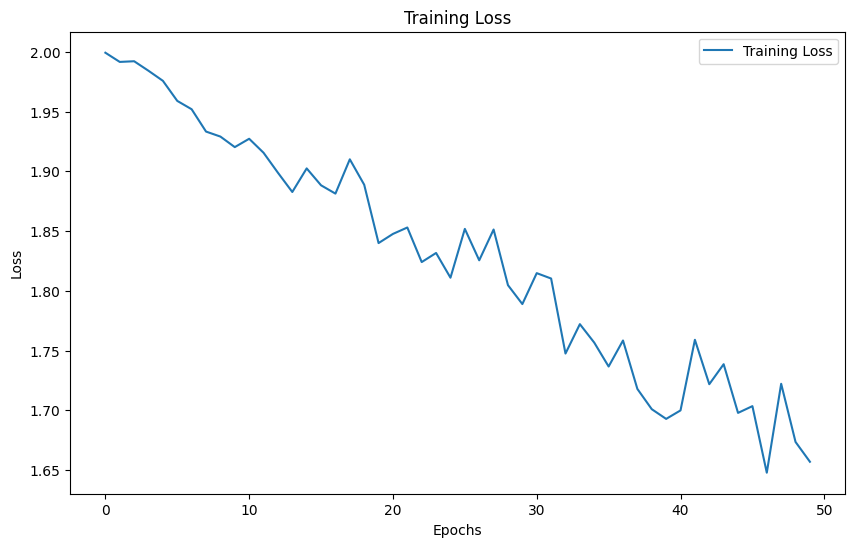

In [60]:
#Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Test Transformer

In [61]:
# testing loop
transformer.eval()

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
test_losses=[]
val_outputs = []
with torch.no_grad():
    test_loss=0
    for x, y in test_dataloader:
        print(x.shape)
        print(y.shape)
        val_output = transformer(x)
        
        val_y=y.transpose(1,2)
        
        loss = criterion(val_output, val_y)
        print(f"Validation Loss: {loss.item()}")
        
        test_loss += loss.item()
        val_outputs.append(val_y)
    
    test_loss /= len(test_dataloader) #mean loss of batch
    test_losses.append(test_loss)
print('Avg loss: ', test_losses)

torch.Size([1, 2, 20])
torch.Size([1, 2, 20])
Validation Loss: 1.3851174116134644
torch.Size([1, 2, 20])
torch.Size([1, 2, 20])
Validation Loss: 0.4063374996185303
torch.Size([1, 2, 20])
torch.Size([1, 2, 20])
Validation Loss: 4.317397117614746
Avg loss:  [2.03628400961558]


In [62]:
# define evaluation functions

def plot_predictions_vs_actual(predictions, actual, title='Predictions vs Actual'):
    """ 
    Plot the actual vs predicted results for data related to a given function of u

    Args:
        predictions (tensor): predicted values (y)
        actual (tensor): actual values including x (inputs) and y (expected output)
        title (str, optional): Title of plot. Defaults to 'Predictions vs Actual'.
    """
    plt.figure(figsize=(6, 4))

    val=""

    for i in range(actual.shape[1]):
        if i ==1:
            val = 'u'
        else:
            val = 'x'
        
        # print('actual: ',actual[:,i])
        # print('predicted: ',predictions[:,i])
        plt.plot(test_time[0], actual[:,i], '-o',label=f'Actual Values {val}')
        plt.plot(test_time[0,actual.shape[0]-predictions.shape[0]:],predictions[:,i],'--x', label=f'Predicted Values {val}')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
def rmse_r2(predictions, actual, description ):
    """Calculates goodness of fit using:
    (1) The root mean square error (RMSE) 
    (2) The coefficient of determination (R^2)

    Args:
        predictions: predicted values of x,u 
        actual: expected values of x,u 
        description (_type_): data description

    Returns:
        float: rmse , r_squared
    """
    rmse = []
    r_squared = []
    for i in range(actual.shape[1]):
        rmse.append(np.sqrt(mean_squared_error(actual[:,i], predictions[:,i])))
        r_squared.append(r2_score(actual[:,i], predictions[:,i]))

    df = pd.DataFrame({
        'Description': [description, description],
        'Metric': ['Test RMSE', 'Test R²'],
        'x': [rmse[0], r_squared[0]],
        'u': [rmse[1], r_squared[1]]})

    # Display the DataFrame
    print(df)
    
    return rmse, r_squared
    

  Description     Metric    x    u
0  Function 1  Test RMSE  0.0  0.0
1  Function 1    Test R²  1.0  1.0


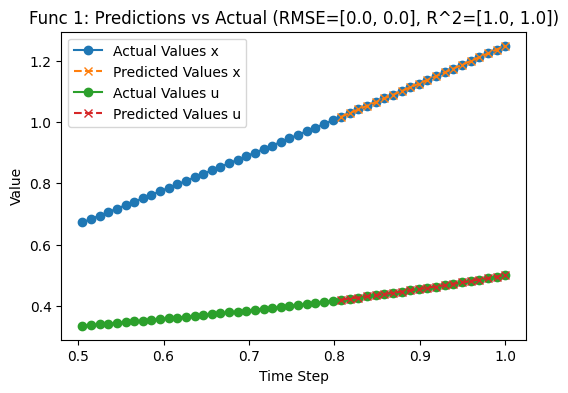

In [63]:
#Metrics function 1
test_array_tensor = torch.tensor(test_array, dtype=torch.float32)
#print(val_outputs[0]-y_test_tensor.transpose(1,2)[0,:,:])
#print('full test sequence',test_array_tensor)

rmse, r_squared = rmse_r2(val_outputs[0].squeeze(0),y_test_tensor.transpose(1,2)[0,:,:], 'Function 1')
plot_predictions_vs_actual(val_outputs[0].squeeze(0),test_array_tensor[0,:,:], f'Func 1: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')



  Description     Metric    x    u
0  Function 2  Test RMSE  0.0  0.0
1  Function 2    Test R²  1.0  1.0


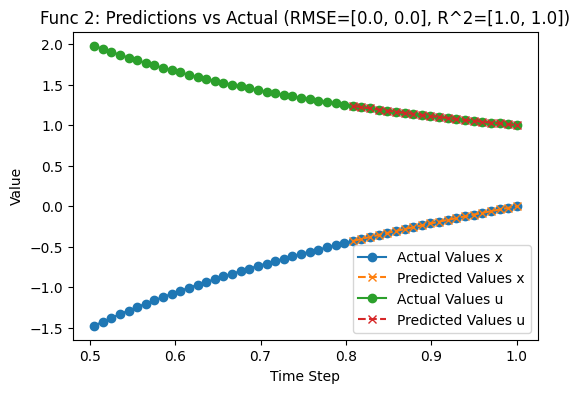

In [64]:
#Metrics function 2
# print(val_outputs[1].squeeze(0).shape)
# print(test_array_tensor)
rmse_r2(val_outputs[1].squeeze(0),y_test_tensor.transpose(1,2)[1,:,:], 'Function 2')
plot_predictions_vs_actual(val_outputs[1].squeeze(0),test_array_tensor[1,:,:], f'Func 2: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')

  Description     Metric    x    u
0  Function 3  Test RMSE  0.0  0.0
1  Function 3    Test R²  1.0  1.0


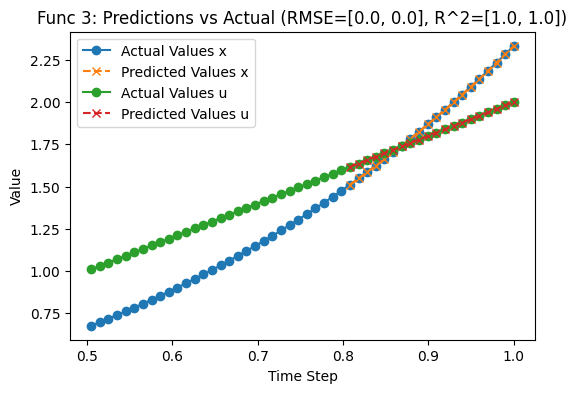

In [65]:
#Metrics function 3

rmse_r2(val_outputs[2].squeeze(0),y_test_tensor.transpose(1,2)[2,:,:], 'Function 3')
plot_predictions_vs_actual(val_outputs[2].squeeze(0),test_array_tensor[2,:,:], f'Func 3: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})') #plot for x